<a href="https://colab.research.google.com/github/Munenyashaishe/Crop_Yield_Research/blob/main/Crop_Yield_Pred_Khan_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RESEARCH ON CROP YIELD PREDICTION, CASE STUDY OF : KENYA FARMS**

A remodelling of Assanizz's research

# **Preliminary Steps**

Load Data

In [ ]:
#https://drive.google.com/u/0/uc?id=1u9rA-QXlgoGjzhecwYWERkDe2XU244w8&export=download

In [1]:
!gdown --id 1u9rA-QXlgoGjzhecwYWERkDe2XU244w8  
!unzip -q '/content/Crop_data.zip'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1u9rA-QXlgoGjzhecwYWERkDe2XU244w8
To: /content/Crop_data.zip
100% 928M/928M [00:10<00:00, 85.9MB/s]


In [2]:
%%time
# Extract
!unzip -q '/content/Crop_data/image_arrays_test.zip'
!unzip -q '/content/Crop_data/image_arrays_train.zip'

CPU times: user 661 ms, sys: 78.3 ms, total: 739 ms
Wall time: 1min 25s


In [3]:
# Copying in the zip files from Google Drive 
!cp '/content/Crop_data/Train.csv' .
!cp '/content/Crop_data/SampleSubmission.csv' .
!cp '/content/Crop_data/bandnames.txt' .
!cp '/content/Crop_data/fields_w_additional_info.csv' .

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


# **Exploring Images**

Loading image_arrays_train/7M6VMQ1.npy as an array
Array shape: (360, 41, 41)


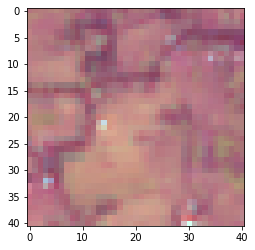

In [7]:
# Look at a sample:
fid = train['Field_ID'].sample().values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

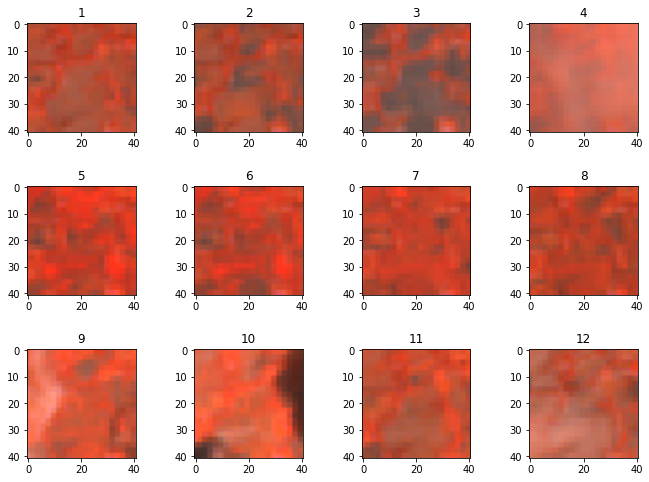

In [8]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

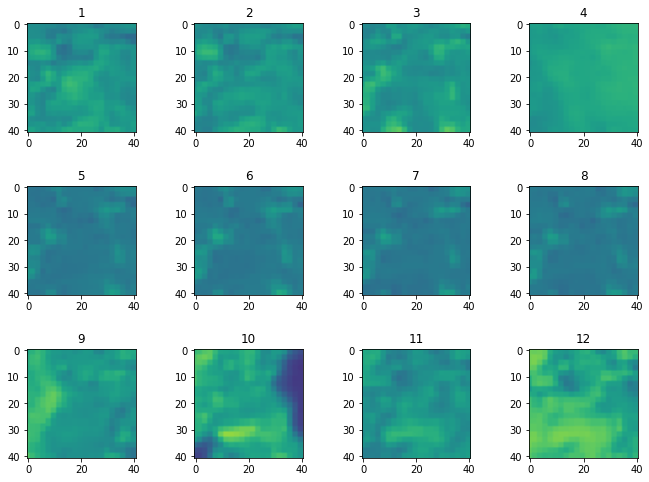

In [9]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

## **Chapter 1:  Vegetation Index Data Creation**

The Vegetation dataset index is created from some statistics over : NDVI , GRNDVI , EVI , SAVI , CCCI . statistics used are :

MEDIAN ( recommended by experts )  [ NDVI , GRNDVI , EVI ]
MAX  [NDVI , GRNDVI , EVI , SAVI , CCCI ]
MIN [NDVI , GRNDVI ]

Step 2 : Referred to some visualization  we discover that NDVI, SAVI, GRNDVI have the same distribution for specific months  . so we created a function that create over those months :

Products of NDVI, SAVI, GRNDVI features
std of NDVI, SAVI, GRNDVI features
mean of NDVI, SAVI, GRNDVI features

Step 3 : apply Yeo-Johnson transformation to transform data distribution to a NORMAL Distribution .

# **Helpers**





 >  **Instead of using all the Additional Data , we will use some statictics over 4 Years :** 
```
1.   Average Over 4 Years By Each Month in Maize Season in kenya for some Climat Variables 
2.   Select Specific Soil Features
```

 








In [10]:
def addtional_is_Useful(additional,soil_cols) : 
  
  additional_ = pd.DataFrame()
  climat = ['pr','tmmn','tmmx'] 

  for month in range(3,10) :  
    for  climat_ in climat :
      features_ = []
      for year in [2016,2017,2018,2019] :
          features_.append('climate_'+str(year) + '_' + str(month) + f'_{climat_}' )
      additional_[f'ADDITIONAL_PER_4_YEARS_mean_{month-1}_{climat_}'] = additional[features_].mean(axis=1)
  
  # Soil Columns
  for col in special_cols : 
    additional_[col] = additional[col]
  return additional_

## **Vegetation - Indexs**

### **1. NDVI (Normalized Difference Vegetation  Indexes)**



> **General formula: (MIR - NIR) / (MIR + NIR)**



In [11]:
def get_NDVI_data(fid, folder='image_arrays_train') :
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands_of_interest = ['S2_B4', 'S2_B8']
  values = {}
  
  for month in range(12): 
    bns = [str(month) + '_' + b for b in bands_of_interest] 
    idxs = np.where(np.isin(band_names, bns)) 
    
    NDVI_arr = (arr[idxs][1].astype(int)-arr[idxs][0].astype(int)) / (arr[idxs][1].astype(int)+arr[idxs][0].astype(int))
    values['NDVI_Median_'+str(month)] = np.median(NDVI_arr)
  
  for month in [0,3,4,5,6,7,8,9,10]: 
    bns = [str(month) + '_' + b for b in bands_of_interest] 
    idxs = np.where(np.isin(band_names, bns)) 
    
    NDVI_arr = (arr[idxs][1].astype(int)-arr[idxs][0].astype(int)) / (arr[idxs][1].astype(int)+arr[idxs][0].astype(int))
    values['NDVI_Min_'+str(month)] = NDVI_arr.min()
    values['NDVI_Max_'+str(month)] = NDVI_arr.max()
 
  return values

### **2. EVI (Enhanced Vegetation Index)**



> **General formula: 2.5 * (NIR - RED) / ((NIR + 6*RED - 7.5*BLUE) + 1)**



In [12]:
def get_EVI_data(fid, folder='image_arrays_train') :
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands_of_interest = ['S2_B4', 'S2_B8','S2_B2']
  values = {}
  
  for month in range(12): 
    bns = [str(month) + '_' + b for b in bands_of_interest] 
    idxs = np.where(np.isin(band_names, bns)) 
    B08 = arr[idxs][1].astype(int)
    B04 = arr[idxs][0].astype(int)
    B02 = arr[idxs][2].astype(int)
    
    EVI_arr = 2.5 * (B08 - B04) / ((B08 + 6.0 * B04 - 7.5 * B02) + 1.0)
    values['EVI_Median_'+str(month)] = np.median(EVI_arr)
  
  for month in [2,3,4,5,6,7,8,9,10,11]:
    bns = [str(month) + '_' + b for b in bands_of_interest] 
    idxs = np.where(np.isin(band_names, bns)) 
    B08 = arr[idxs][1].astype(int)
    B04 = arr[idxs][0].astype(int)
    B02 = arr[idxs][2].astype(int)
    
    EVI_arr = 2.5 * (B08 - B04) / ((B08 + 6.0 * B04 - 7.5 * B02) + 1.0)
    values['EVI_Max_'+str(month)] = EVI_arr.max()
  
  return values

### **3. SAVI (Soil Adjusted Vegetation Index)**



> **General formula : (B08 - B04) / (B08 + B04 + L) * (1.0 + L)**



In [13]:
def get_SAVI_data(fid, folder='image_arrays_train') :
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands_of_interest = ['S2_B4', 'S2_B8']
  L = 0.725
  values = {}
  
  for month in range(12): 
    bns = [str(month) + '_' + b for b in bands_of_interest] 
    idxs = np.where(np.isin(band_names, bns)) 
    B08 = arr[idxs][1].astype(int)
    B04 = arr[idxs][0].astype(int)
    
    SAVI_arr = (B08 - B04) / (B08 + B04 + L) * (1.0 + L)
    values['SAVI_Max_'+str(month)] = SAVI_arr.max()
  
  return values

2nd part :  Transform the Additional DATA
After doing some research and referring to some experts, we found that :

Maize Season in Kenya is from mars to October.
Precipitation, Minimum temperature, Maximum temperature.
soil features are very useful.
so we created a function that transforms the Additional data by Calculating the mean over 4 years from 3rd 3 to month 10. For example :

we take month 3 and then we create a feature average_per_4Years_on_month_3 which is the mean over [ month_3_2016,month_3_2017,month_3_2018,month_3_2019 ] and like that ....

3rd part : Create Red Bands DataSet
We created features from statistics over relation between Red Bands (this is also recommended by some experts in this field) For example, we calculate for month 5 :

step 1 : b7_b6_array = 5_S2_B7 / 5_S2_B6
step 2 : we calculate the median over the resulting array
And Finally, we concatenated those Datasets to get a 233 features dataset.

Btw in this approach, we're using only quality 1 and 3, adding quality 2 improves CV but makes LB very Bad.3rd part : Create Red Bands DataSet
We created features from statistics over relation between Red Bands (this is also recommended by some experts in this field) For example, we calculate for month 5 :

step 1 : b7_b6_array = 5_S2_B7 / 5_S2_B6
step 2 : we calculate the median over the resulting array
And Finally, we concatenated those Datasets to get a 233 features dataset.

Btw in this approach, we're using only quality 1 and 3, adding quality 2 improves CV but makes LB very Bad.

## **Features From Red Bands**

In [14]:
def get_features_fromBands(fid, folder='image_arrays_train',bands=None,Band_Names=None) :
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  
  final_values = {}
  for bands_idx in range(len(bands)) : 
    bands_of_interest = bands[bands_idx]
    Name = Band_Names[bands_idx]
    values = {}
    for month in range(12):
      bns = [str(month) + '_' + b for b in bands_of_interest] 
      idxs = np.where(np.isin(band_names, bns)) 
      Relation_arr = arr[idxs][1].astype(int) / arr[idxs][0].astype(int) 
      
      values[f'BANDS_FEATURES_Median_{Name}_'+str(month)] = np.median(Relation_arr)
    
    final_values.update(values)
  return final_values

# **Data - Preparation**

In [15]:
import pandas as pd 
import numpy as np  
from matplotlib import pyplot as plt  
import seaborn as sns
import warnings

import tqdm 
from tqdm import tqdm_notebook as tqdm 
warnings.simplefilter('ignore')

In [16]:
#/content/test_field_ids_with_year.csv#

In [17]:
# Load   -- Train | additional | sampleSubmission 

train = pd.read_csv('Train.csv')
additional = pd.read_csv('fields_w_additional_info.csv')
ss = pd.read_csv('SampleSubmission.csv')

ss_year= pd.read_csv('/content/test_field_ids_with_year.csv') # upload it in your local session

print('| train shape :' , train.shape,'  |   test shape : ',ss.shape, '  |   addtional shape : ',additional.shape,'  |  ')

| train shape : (2977, 4)   |   test shape :  (1055, 2)   |   addtional shape :  (4032, 684)   |  


In [18]:
### Additional Data ###
special_cols =   additional.columns[:12]   
additional_ = addtional_is_Useful(additional,special_cols)

print(additional_.shape)
additional_.head()

(4032, 33)


,ADDITIONAL_PER_4_YEARS_mean_2_pr,ADDITIONAL_PER_4_YEARS_mean_2_tmmn,ADDITIONAL_PER_4_YEARS_mean_2_tmmx,ADDITIONAL_PER_4_YEARS_mean_3_pr,ADDITIONAL_PER_4_YEARS_mean_3_tmmn,ADDITIONAL_PER_4_YEARS_mean_3_tmmx,ADDITIONAL_PER_4_YEARS_mean_4_pr,ADDITIONAL_PER_4_YEARS_mean_4_tmmn,ADDITIONAL_PER_4_YEARS_mean_4_tmmx,ADDITIONAL_PER_4_YEARS_mean_5_pr,...,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_ocs_0-30cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean
0,41.25,113.25,287.75,138.50,119.00,276.25,156.25,115.50,262.50,109.75,...,257.0,85.0,463.0,2458.0,323.0,57.0,59.0,308.0,229.0,330.0
1,39.75,112.50,296.00,127.25,113.75,282.25,133.25,111.25,271.75,106.25,...,288.0,84.0,462.0,2108.0,306.0,58.0,61.0,243.0,295.0,280.0
2,40.25,114.50,296.75,130.25,116.25,283.25,133.25,112.50,272.50,103.75,...,263.0,102.0,495.0,1991.0,288.0,58.0,60.0,271.0,234.0,284.0
3,40.00,114.25,286.00,139.00,119.00,274.25,162.75,116.75,261.50,112.00,...,206.0,66.0,431.0,2432.0,337.0,65.0,57.0,332.0,237.0,335.0
4,78.50,161.75,311.25,228.75,162.75,295.25,214.50,157.00,285.25,120.75,...,167.0,116.0,439.0,566.0,302.0,53.0,56.0,326.0,235.0,187.0


In [19]:
# working only with poor and good quality
train = train[train['Quality'].isin([1,3])]  # only quality 1 - 3 

In [20]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

## 1 - **Vegetation Indexs**

In [21]:
                                                      ###  Get NDVI Data    ###

train_NDVI = pd.DataFrame([get_NDVI_data(train['Field_ID'].values[fid_idx]) for fid_idx in tqdm(range(len(train['Field_ID'].values))) ])
train_NDVI['Field_ID'] = train['Field_ID'].values

print()

test_NDVI = pd.DataFrame([get_NDVI_data(ss['Field_ID'].values[fid_idx], folder='image_arrays_test') for fid_idx in tqdm(range(len(ss['Field_ID'].values)))])
test_NDVI['Field_ID'] = ss['Field_ID'].values

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/1055 [00:00<?, ?it/s]

In [22]:
train_NDVI.head()

,NDVI_Median_0,NDVI_Median_1,NDVI_Median_2,NDVI_Median_3,NDVI_Median_4,NDVI_Median_5,NDVI_Median_6,NDVI_Median_7,NDVI_Median_8,NDVI_Median_9,...,NDVI_Max_6,NDVI_Min_7,NDVI_Max_7,NDVI_Min_8,NDVI_Max_8,NDVI_Min_9,NDVI_Max_9,NDVI_Min_10,NDVI_Max_10,Field_ID
0,0.514644,0.398194,0.342726,0.340072,0.458077,0.031556,0.589358,0.399567,0.673010,0.675813,...,0.788367,0.114936,0.761976,0.189881,0.808649,0.331603,0.823542,0.343478,0.823981,MH2O0YH
1,0.348010,0.297969,0.250628,0.237860,0.285620,0.025184,0.757973,0.664011,0.589613,0.565794,...,0.824188,-0.006041,0.794096,0.175996,0.785395,0.271372,0.809500,0.200753,0.794067,35AFSDD
2,0.356450,0.228688,0.256365,0.325984,0.679453,0.681313,0.645152,0.435045,0.503568,0.553453,...,0.759837,0.171462,0.713958,0.240765,0.749432,0.256592,0.787282,0.070945,0.608659,003GQB5
3,0.425717,0.317039,0.373182,0.400500,0.669710,0.665569,0.632975,0.545375,0.586897,0.588719,...,0.743554,0.047642,0.749370,0.033887,0.787587,0.067895,0.799002,0.061938,0.523440,A6H2141
4,0.382446,0.321937,0.308539,0.323252,0.655968,0.498312,0.637804,0.460905,0.498201,0.533890,...,0.752027,0.203966,0.697697,0.219638,0.753298,0.229847,0.742220,0.258270,0.711571,MHDYMRX


In [23]:
                                                      ###  Get EVI Data    ###

train_EVI = pd.DataFrame([get_EVI_data(train['Field_ID'].values[fid_idx]) for fid_idx in tqdm(range(len(train['Field_ID'].values))) ])
train_EVI['Field_ID'] = train['Field_ID'].values

print()

test_EVI = pd.DataFrame([get_EVI_data(ss['Field_ID'].values[fid_idx], folder='image_arrays_test') for fid_idx in tqdm(range(len(ss['Field_ID'].values)))])
test_EVI['Field_ID'] = ss['Field_ID'].values

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/1055 [00:00<?, ?it/s]

In [24]:
train_EVI.head()

,EVI_Median_0,EVI_Median_1,EVI_Median_2,EVI_Median_3,EVI_Median_4,EVI_Median_5,EVI_Median_6,EVI_Median_7,EVI_Median_8,EVI_Median_9,...,EVI_Max_3,EVI_Max_4,EVI_Max_5,EVI_Max_6,EVI_Max_7,EVI_Max_8,EVI_Max_9,EVI_Max_10,EVI_Max_11,Field_ID
0,0.011392,-0.014700,-0.025601,-0.022997,0.011128,-0.073845,0.157672,0.051144,0.027857,0.026926,...,0.072925,0.091708,0.336533,0.661550,0.540337,0.091768,0.109226,0.140126,1.454623,MH2O0YH
1,-0.036128,-0.059792,-0.086052,-0.070615,-0.044259,-0.087945,0.034176,0.037643,0.020576,0.015035,...,0.058378,0.094889,0.568373,0.090519,0.080588,0.089441,0.067995,0.064794,0.316553,35AFSDD
2,-0.023970,-0.095323,-0.087615,-0.045102,0.036156,0.036662,0.037917,0.010020,0.004706,0.007825,...,0.064216,0.079021,0.068591,0.097185,0.166929,0.051491,0.119019,0.292084,0.752592,003GQB5
3,0.007674,-0.032616,-0.021169,-0.006093,0.037565,0.038745,0.040024,0.030199,0.024119,0.022476,...,0.782186,0.921471,0.220758,0.214402,0.337069,0.256648,0.219630,4.056795,11.256158,A6H2141
4,-0.010871,-0.041784,-0.057120,-0.035096,0.035926,0.036115,0.034557,0.019048,0.011620,0.010115,...,0.083985,0.093456,0.226337,0.088243,0.067544,0.080760,0.057059,0.072753,0.130955,MHDYMRX


In [25]:
                                                      ###  Get SAVI Data    ###

train_SAVI = pd.DataFrame([get_SAVI_data(train['Field_ID'].values[fid_idx]) for fid_idx in tqdm(range(len(train['Field_ID'].values))) ])
train_SAVI['Field_ID'] = train['Field_ID'].values

print()

test_SAVI = pd.DataFrame([get_SAVI_data(ss['Field_ID'].values[fid_idx], folder='image_arrays_test') for fid_idx in tqdm(range(len(ss['Field_ID'].values)))])
test_SAVI['Field_ID'] = ss['Field_ID'].values

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/1055 [00:00<?, ?it/s]

In [26]:
train_SAVI.head()

,SAVI_Max_0,SAVI_Max_1,SAVI_Max_2,SAVI_Max_3,SAVI_Max_4,SAVI_Max_5,SAVI_Max_6,SAVI_Max_7,SAVI_Max_8,SAVI_Max_9,SAVI_Max_10,SAVI_Max_11,Field_ID
0,1.387860,1.340256,1.297018,1.259120,1.308096,0.157630,1.359721,1.314205,1.394693,1.420397,1.421159,1.376860,MH2O0YH
1,1.197964,1.126216,1.106721,0.969667,1.115649,0.353729,1.421529,1.369574,1.354562,1.396139,1.369522,1.386767,35AFSDD
2,1.103363,1.109366,1.122095,1.170232,1.420081,1.380349,1.310504,1.231322,1.292504,1.357840,1.049775,1.423170,003GQB5
3,1.242593,1.275071,1.209281,1.189709,1.432710,1.364676,1.282412,1.292426,1.358397,1.378101,0.902722,1.266213,A6H2141
4,1.042626,1.074357,1.022653,1.121090,1.436992,1.293338,1.297022,1.203318,1.299221,1.280114,1.227244,0.494353,MHDYMRX


* **std_mean_per_month_vegetation**

In [27]:
def std_mean_product_per_month_vegetation(data_NDVI,data_GRNDVI,data_SAVI) : 
  std_Mean_dataset = pd.DataFrame()
  std_Mean_dataset['Field_ID'] = data_NDVI['Field_ID']
  for month in [0,3,4,5,6,7,8,9,10]: 
      local = pd.DataFrame()
      features = []
      feature_NDVI = 'NDVI_Max_' + str(month)
      local[feature_NDVI] = data_NDVI[feature_NDVI]
      features.append(feature_NDVI)
      feature_SAVI = 'SAVI_Max_' + str(month)
      local[feature_SAVI] = data_SAVI[feature_SAVI]
      features.append(feature_SAVI)
      
      std_feature = local[features].std(axis=1)
      std_Mean_dataset[f'STD_MAX_FOR_MONTH_{month}'] = std_feature

      product_feature = local[features].prod(axis=1)
      std_Mean_dataset[f'PRODUCT_MAX_FOR_MONTH_{month}'] = product_feature
      
      mean_feature = local[features].mean(axis=1)
      std_Mean_dataset[f'MEAN_MAX_FOR_MONTH_{month}'] = mean_feature

  return std_Mean_dataset

In [28]:
#train_std_mean = std_mean_product_per_month_vegetation(train_NDVI,train_GRNDVI,train_SAVI)
#test_std_mean = std_mean_product_per_month_vegetation(test_NDVI,test_GRNDVI,test_SAVI)
#train_std_mean.shape , test_std_mean.shape

In [29]:
train_std_mean = std_mean_product_per_month_vegetation(train_NDVI,train_EVI,train_SAVI)
test_std_mean = std_mean_product_per_month_vegetation(test_NDVI,test_EVI,test_SAVI)
train_std_mean.shape , test_std_mean.shape

((1746, 28), (1055, 28))

* **get_Vegetation_indexs_Data**

In [30]:
train_NDVI_ = train_NDVI
train_SAVI_ = train_SAVI
train_EVI_ = train_EVI

test_NDVI_ = test_NDVI
test_SAVI_ = test_SAVI
test_EVI_ = test_EVI

In [31]:
def get_Vegetation_indexs_Data() :

  # TRAIN
  NDVI_SAVI = pd.merge(train_NDVI_,train_SAVI_,on='Field_ID',how='left')
  NDVI_SAVI_EVI = pd.merge(NDVI_SAVI,train_EVI_,on='Field_ID',how='left')

  TRAIN = NDVI_SAVI_EVI.copy()
  TRAIN = pd.merge(TRAIN,train_std_mean,on='Field_ID',how='left')
  
  # TEST
  NDVI_SAVI = pd.merge(test_NDVI_,test_SAVI_,on='Field_ID',how='left')
  NDVI_SAVI_EVI = pd.merge(NDVI_SAVI,test_EVI_,on='Field_ID',how='left')
  
  TEST = NDVI_SAVI_EVI.copy()
  TEST = pd.merge(TEST,test_std_mean,on='Field_ID',how='left')
  
  return TRAIN, TEST

In [32]:
train_vegetation_indexs , test_vegetation_indexs  = get_Vegetation_indexs_Data() 

In [33]:
train_vegetation_indexs.shape, test_vegetation_indexs.shape

((1746, 92), (1055, 92))

## 2 - **Red Band Features**

In [34]:
bands = [ ['S2_B7','S2_B5'] ,['S2_B7','S2_B6']] 
names = ['FEATURES_B7_B5','FEATURES_B7_B6']  

In [35]:
train_Features = pd.DataFrame([get_features_fromBands(train['Field_ID'].values[fid_idx],bands=bands,Band_Names=names) for fid_idx in tqdm(range(len(train['Field_ID'].values))) ])
train_Features['Field_ID'] = train['Field_ID'].values

print()

test_Features = pd.DataFrame([get_features_fromBands(ss['Field_ID'].values[fid_idx],folder='image_arrays_test',bands=bands,Band_Names=names) for fid_idx in tqdm(range(len(ss['Field_ID'].values))) ])
test_Features['Field_ID'] = ss['Field_ID'].values

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/1055 [00:00<?, ?it/s]

In [36]:
train_Features.shape,test_Features.shape

((1746, 25), (1055, 25))

## **4 - Create Data**

In [37]:
def Create_data() :
  train1 = pd.merge(train_vegetation_indexs,train_Features,on='Field_ID',how='left')
  train2 = pd.merge(train1,additional_,on='Field_ID',how='left')

  test1 = pd.merge(test_vegetation_indexs,test_Features,on='Field_ID',how='left')
  test2 = pd.merge(test1,additional_,on='Field_ID',how='left')

  return train2,test2

In [38]:
final_train,final_test = Create_data()

In [39]:
final_train.shape , final_test.shape

((1746, 148), (1055, 148))

In [40]:
train = train.reset_index(drop=True)

4th part : Modeling
Using  5 Kfold splits with shuffle =True.
Wokring with Xgboost with colsample_bytree = 0.65 .
in this Approach Our cv is 1.59 - LB is 1.65.

Second Approach :
The second approach involved splitting the training set into two, good quality fields and bad quality fields.

Good quality data included quality 2 and 3
bad quality data included quality 1 fields.
Only good quality data was used for validation as the test set had only quality 2 and 3 fields.

Vegetation features used in this approach included : WDRVI, GNDVI, NDVI and NDRE only. Raw image pixel data was not used in training. Lightgbm was trained across five-folds with a CV score of 1.66 and a private LB score of 1.64

# **Modeling**

## **Xgboost**

#training dataset model fitting

In [41]:
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
X, y  = final_train.drop(['Field_ID'],axis=1), train['Yield']

kf = KFold(n_splits =5,shuffle=True,random_state=160)
feats = pd.DataFrame({'features': X.columns}) 
gbm_predictions = []
cv_score_ = 0
oof_preds = np.zeros((train.shape[0],))


for i,(tr_index,test_index) in enumerate(kf.split(X,y)):
  
  print()
  print(f'######### FOLD {i+1} / {kf.n_splits} ')
  
  X_train,y_train = X.iloc[tr_index,:],y[tr_index]
  X_test,y_test = X.iloc[test_index,:],y[test_index]
  
  gbm = xgb.XGBRegressor(eval_metric = 'rmse',n_estimators = 2000,learning_rate = 0.01,seed=162,random_state = 162,colsample_bytree=0.65)

  gbm.fit(X_train,y_train,eval_set = [(X_test, y_test)],early_stopping_rounds  = 200,verbose=100)
  
  cv_score_ += mean_squared_error(y_test, gbm.predict(X_test), squared=False) / kf.n_splits
  oof_preds[test_index] = gbm.predict(X_test)
  
  preds = gbm.predict(final_test[X_train.columns])
  gbm_predictions.append(preds)

  feats[f'Fold {i}'] = gbm.feature_importances_

feats['Importances'] = feats.mean(axis=1)
print( ' CV RMSE : ',cv_score_)
preds_xgb = np.average(gbm_predictions, axis=0)
print(preds_xgb.shape)


######### FOLD 1 / 5 
[08:25:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.11277
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:1.85876
[200]	validation_0-rmse:1.61613
[300]	validation_0-rmse:1.58372
[400]	validation_0-rmse:1.58064
[500]	validation_0-rmse:1.58332
Stopping. Best iteration:
[370]	validation_0-rmse:1.57992


######### FOLD 2 / 5 
[08:25:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.13362
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:1.76611
[200]	validation_0-rmse:1.49792
[300]	validation_0-rmse:1.46448
[400]	validation_0-rmse:1.46639
[500]	validation_0-rmse:1.46884
Stopping. Best iteration:
[324]	validation_0-rmse:1.46303


######### FOLD 3 / 5 
[08:25:15] WARNING: /workspace/src/objective/re

In [42]:
# Get model predictions
ss['Yield'] = preds_xgb
ss.to_csv('CGIAR_Submission.csv', index=False)  
ss.head()

,Field_ID,Yield
0,E9UZCEA,2.361935
1,1WGGS1Q,2.870892
2,EG2KXE2,2.527625
3,HC3GQXF,2.390424
4,7AK6GFK,2.436687


### **Feature_selection**

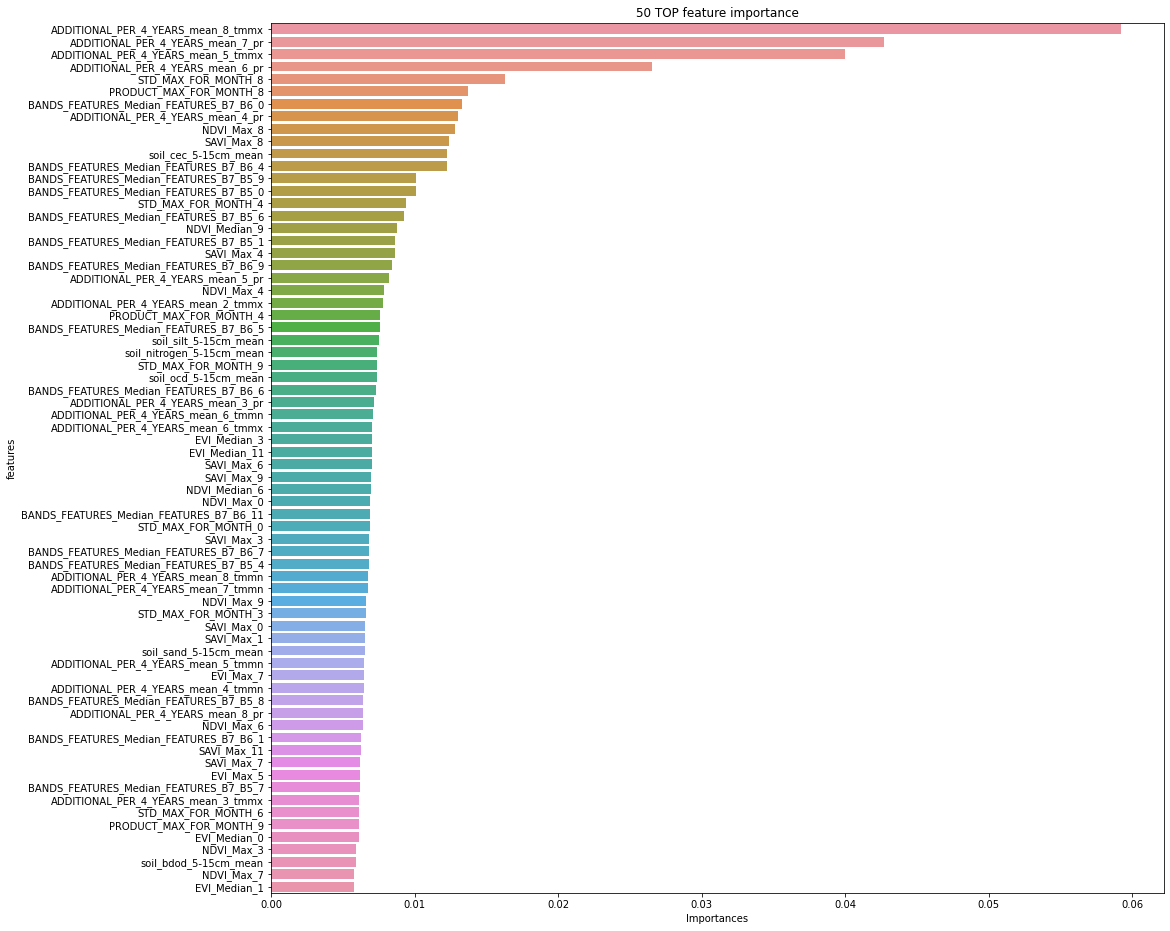

In [43]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feats.sort_values(by='Importances', ascending=False).head(70), x='Importances', y='features');
plt.title('50 TOP feature importance');